In [34]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import math
import seaborn as sns
sns.set_style('whitegrid')
import matplotlib.pyplot as plt
plt.style.use("fivethirtyeight")

from statsmodels.tsa.seasonal import seasonal_decompose
from scipy.fft import fft

import keras
from keras.models import Sequential
from keras.callbacks import EarlyStopping
from keras.layers import Dense, LSTM, Dropout

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/london-weather-data-from-1979-to-2023/london_weather_data_1979_to_2023.csv


In [2]:
data_dir = '/kaggle/input//london-weather-data-from-1979-to-2023/london_weather_data_1979_to_2023.csv'
data = pd.read_csv(data_dir, parse_dates= True , index_col= "DATE")

In [3]:
data.head()

,TX,Q_TX,TN,Q_TN,TG,Q_TG,SS,Q_SS,SD,Q_SD,RR,Q_RR,QQ,Q_QQ,PP,Q_PP,HU,Q_HU,CC,Q_CC
DATE,,,,,,,,,,,,,,,,,,,,
1979-01-01,23.0,0,-75.0,0,-41.0,0,70.0,0,9.0,0,4.0,0,52.0,0,10190.0,0,83.0,0,2.0,0
1979-01-02,16.0,0,-75.0,0,-26.0,0,17.0,0,8.0,0,0.0,0,27.0,0,10253.0,0,76.0,0,6.0,0
1979-01-03,13.0,0,-72.0,0,-28.0,0,0.0,0,4.0,0,0.0,0,13.0,0,10205.0,0,86.0,0,5.0,0
1979-01-04,-3.0,0,-65.0,0,-26.0,0,0.0,0,2.0,0,0.0,0,13.0,0,10084.0,0,68.0,0,8.0,0
1979-01-05,56.0,0,-14.0,0,-8.0,0,20.0,0,1.0,0,0.0,0,29.0,0,10225.0,0,73.0,0,6.0,0


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 16436 entries, 1979-01-01 to 2023-12-31
Data columns (total 20 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   TX      16436 non-null  float64
 1   Q_TX    16436 non-null  int64  
 2   TN      16436 non-null  float64
 3   Q_TN    16436 non-null  int64  
 4   TG      16407 non-null  float64
 5   Q_TG    16436 non-null  int64  
 6   SS      16436 non-null  float64
 7   Q_SS    16436 non-null  int64  
 8   SD      15361 non-null  float64
 9   Q_SD    16436 non-null  int64  
 10  RR      16436 non-null  float64
 11  Q_RR    16436 non-null  int64  
 12  QQ      16411 non-null  float64
 13  Q_QQ    16436 non-null  int64  
 14  PP      16432 non-null  float64
 15  Q_PP    16436 non-null  int64  
 16  HU      16379 non-null  float64
 17  Q_HU    16436 non-null  int64  
 18  CC      16418 non-null  float64
 19  Q_CC    16436 non-null  int64  
dtypes: float64(10), int64(10)
memory usage: 2.6 MB


In [5]:
data.describe()

,TX,Q_TX,TN,Q_TN,TG,Q_TG,SS,Q_SS,SD,Q_SD,RR,Q_RR,QQ,Q_QQ,PP,Q_PP,HU,Q_HU,CC,Q_CC
count,16436.000000,16436.000000,16436.000000,16436.000000,16407.000000,16436.000000,16436.000000,16436.0,15361.000000,16436.000000,16436.000000,16436.0,16411.00000,16436.000000,16432.000000,16436.00000,16379.000000,16436.000000,16418.000000,16436.000000
mean,154.686846,0.068082,76.016427,0.015454,115.373316,0.083962,43.153626,0.0,0.034633,0.588647,16.791738,0.0,119.52020,0.017036,10153.889423,0.00219,76.283717,0.031212,5.256426,0.009978
std,65.741246,0.251895,53.392049,0.123353,57.457444,0.451623,39.992648,0.0,0.519639,2.225223,37.614507,0.0,89.26958,0.355343,105.196268,0.14039,10.520699,0.529104,2.091593,0.297885
min,-62.000000,0.000000,-118.000000,0.000000,-76.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.00000,0.000000,9596.000000,0.00000,33.000000,0.000000,0.000000,0.000000
25%,106.000000,0.000000,36.000000,0.000000,72.000000,0.000000,4.000000,0.0,0.000000,0.000000,0.000000,0.0,42.00000,0.000000,10091.000000,0.00000,69.000000,0.000000,4.000000,0.000000
50%,151.000000,0.000000,78.000000,0.000000,114.000000,0.000000,35.000000,0.0,0.000000,0.000000,0.000000,0.0,96.00000,0.000000,10162.000000,0.00000,77.000000,0.000000,6.000000,0.000000
75%,204.000000,0.000000,118.000000,0.000000,161.000000,0.000000,71.000000,0.0,0.000000,0.000000,16.000000,0.0,187.00000,0.000000,10225.000000,0.00000,84.000000,0.000000,7.000000,0.000000
max,402.000000,1.000000,223.000000,1.000000,309.000000,9.000000,157.000000,0.0,22.000000,9.000000,618.000000,0.0,402.00000,9.000000,10477.000000,9.00000,100.000000,9.000000,9.000000,9.000000


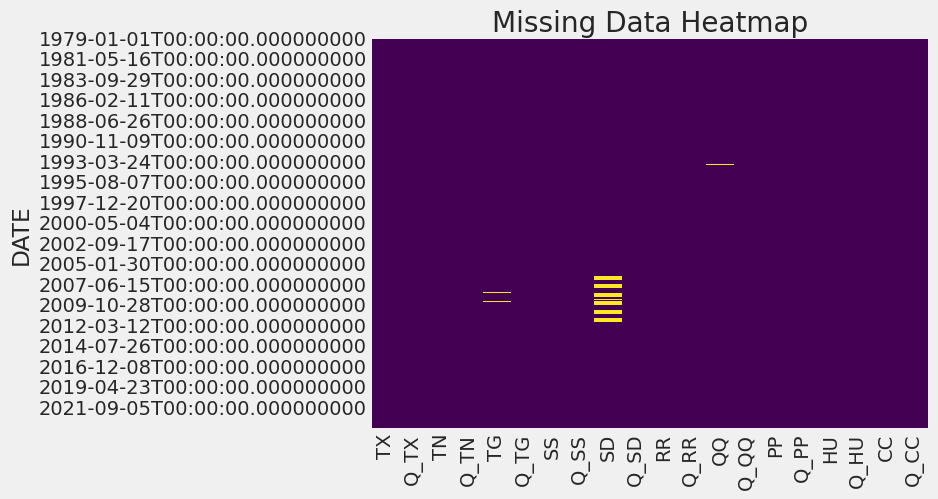

In [6]:
# Visualize missing data
sns.heatmap(data.isnull(), cbar=False, cmap='viridis')
plt.title('Missing Data Heatmap')
plt.show()


In [7]:
# Filter valid data (quality code == 0 for each feature)
valid_data = data[
    (data['Q_TX'] == 0) & 
    (data['Q_TN'] == 0) & 
    (data['Q_TG'] == 0) & 
    (data['Q_SS'] == 0) & 
    (data['Q_RR'] == 0) & 
    (data['Q_QQ'] == 0) & 
    (data['Q_PP'] == 0) & 
    (data['Q_HU'] == 0) & 
    (data['Q_CC'] == 0)
]

valid_data.head()

,TX,Q_TX,TN,Q_TN,TG,Q_TG,SS,Q_SS,SD,Q_SD,RR,Q_RR,QQ,Q_QQ,PP,Q_PP,HU,Q_HU,CC,Q_CC
DATE,,,,,,,,,,,,,,,,,,,,
1979-01-01,23.0,0,-75.0,0,-41.0,0,70.0,0,9.0,0,4.0,0,52.0,0,10190.0,0,83.0,0,2.0,0
1979-01-02,16.0,0,-75.0,0,-26.0,0,17.0,0,8.0,0,0.0,0,27.0,0,10253.0,0,76.0,0,6.0,0
1979-01-03,13.0,0,-72.0,0,-28.0,0,0.0,0,4.0,0,0.0,0,13.0,0,10205.0,0,86.0,0,5.0,0
1979-01-04,-3.0,0,-65.0,0,-26.0,0,0.0,0,2.0,0,0.0,0,13.0,0,10084.0,0,68.0,0,8.0,0
1979-01-05,56.0,0,-14.0,0,-8.0,0,20.0,0,1.0,0,0.0,0,29.0,0,10225.0,0,73.0,0,6.0,0


In [8]:
valid_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 15136 entries, 1979-01-01 to 2023-12-31
Data columns (total 20 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   TX      15136 non-null  float64
 1   Q_TX    15136 non-null  int64  
 2   TN      15136 non-null  float64
 3   Q_TN    15136 non-null  int64  
 4   TG      15136 non-null  float64
 5   Q_TG    15136 non-null  int64  
 6   SS      15136 non-null  float64
 7   Q_SS    15136 non-null  int64  
 8   SD      14112 non-null  float64
 9   Q_SD    15136 non-null  int64  
 10  RR      15136 non-null  float64
 11  Q_RR    15136 non-null  int64  
 12  QQ      15136 non-null  float64
 13  Q_QQ    15136 non-null  int64  
 14  PP      15136 non-null  float64
 15  Q_PP    15136 non-null  int64  
 16  HU      15136 non-null  float64
 17  Q_HU    15136 non-null  int64  
 18  CC      15136 non-null  float64
 19  Q_CC    15136 non-null  int64  
dtypes: float64(10), int64(10)
memory usage: 2.4 MB


In [9]:
# Drop quality columns
valid_data = valid_data.ffill()


In [10]:
valid_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 15136 entries, 1979-01-01 to 2023-12-31
Data columns (total 20 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   TX      15136 non-null  float64
 1   Q_TX    15136 non-null  int64  
 2   TN      15136 non-null  float64
 3   Q_TN    15136 non-null  int64  
 4   TG      15136 non-null  float64
 5   Q_TG    15136 non-null  int64  
 6   SS      15136 non-null  float64
 7   Q_SS    15136 non-null  int64  
 8   SD      15136 non-null  float64
 9   Q_SD    15136 non-null  int64  
 10  RR      15136 non-null  float64
 11  Q_RR    15136 non-null  int64  
 12  QQ      15136 non-null  float64
 13  Q_QQ    15136 non-null  int64  
 14  PP      15136 non-null  float64
 15  Q_PP    15136 non-null  int64  
 16  HU      15136 non-null  float64
 17  Q_HU    15136 non-null  int64  
 18  CC      15136 non-null  float64
 19  Q_CC    15136 non-null  int64  
dtypes: float64(10), int64(10)
memory usage: 2.4 MB


In [11]:
valid_data['TX'] = valid_data['TX'] / 10.0  # Convert to °C
valid_data['TN'] = valid_data['TN'] / 10.0  # Convert to °C
valid_data['TG'] = valid_data['TG'] / 10.0  # Convert to °C
valid_data['SS'] = valid_data['SS'] / 10.0  # Convert to hours
valid_data['RR'] = valid_data['RR'] / 10.0  # Convert to mm
valid_data['PP'] = valid_data['PP'] / 10.0  # Convert to hPa

print(valid_data.head())


             TX  Q_TX   TN  Q_TN   TG  Q_TG   SS  Q_SS   SD  Q_SD   RR  Q_RR  \
DATE                                                                           
1979-01-01  2.3     0 -7.5     0 -4.1     0  7.0     0  9.0     0  0.4     0   
1979-01-02  1.6     0 -7.5     0 -2.6     0  1.7     0  8.0     0  0.0     0   
1979-01-03  1.3     0 -7.2     0 -2.8     0  0.0     0  4.0     0  0.0     0   
1979-01-04 -0.3     0 -6.5     0 -2.6     0  0.0     0  2.0     0  0.0     0   
1979-01-05  5.6     0 -1.4     0 -0.8     0  2.0     0  1.0     0  0.0     0   

              QQ  Q_QQ      PP  Q_PP    HU  Q_HU   CC  Q_CC  
DATE                                                         
1979-01-01  52.0     0  1019.0     0  83.0     0  2.0     0  
1979-01-02  27.0     0  1025.3     0  76.0     0  6.0     0  
1979-01-03  13.0     0  1020.5     0  86.0     0  5.0     0  
1979-01-04  13.0     0  1008.4     0  68.0     0  8.0     0  
1979-01-05  29.0     0  1022.5     0  73.0     0  6.0     0  


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


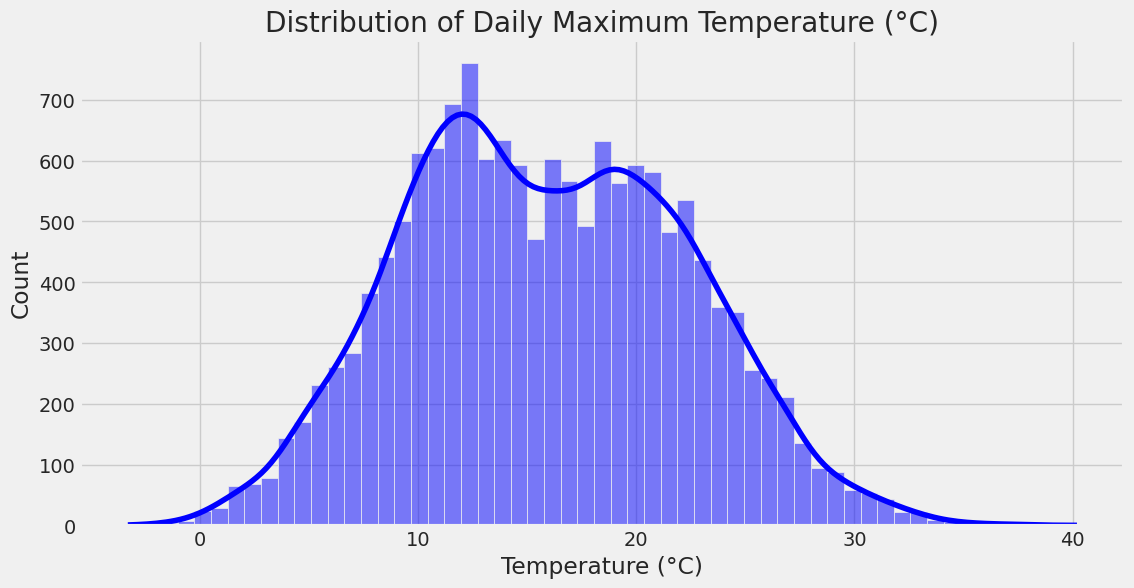

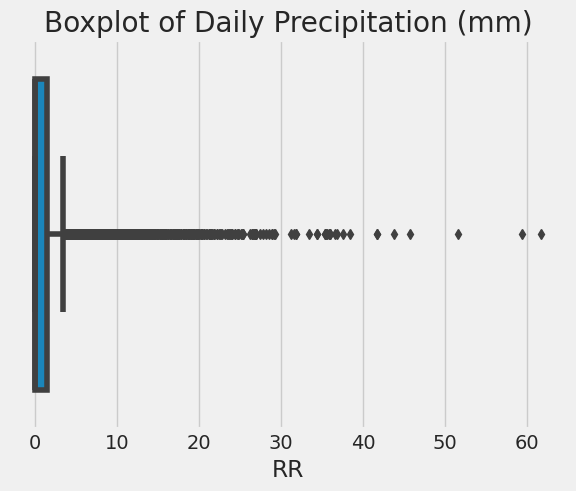

In [12]:
# Temperature Distribution
plt.figure(figsize=(12, 6))
sns.histplot(valid_data['TX'], kde=True, color='blue')
plt.title('Distribution of Daily Maximum Temperature (°C)')
plt.xlabel('Temperature (°C)')
plt.show()

# Boxplot for precipitation
sns.boxplot(x=valid_data['RR'])
plt.title('Boxplot of Daily Precipitation (mm)')
plt.show()


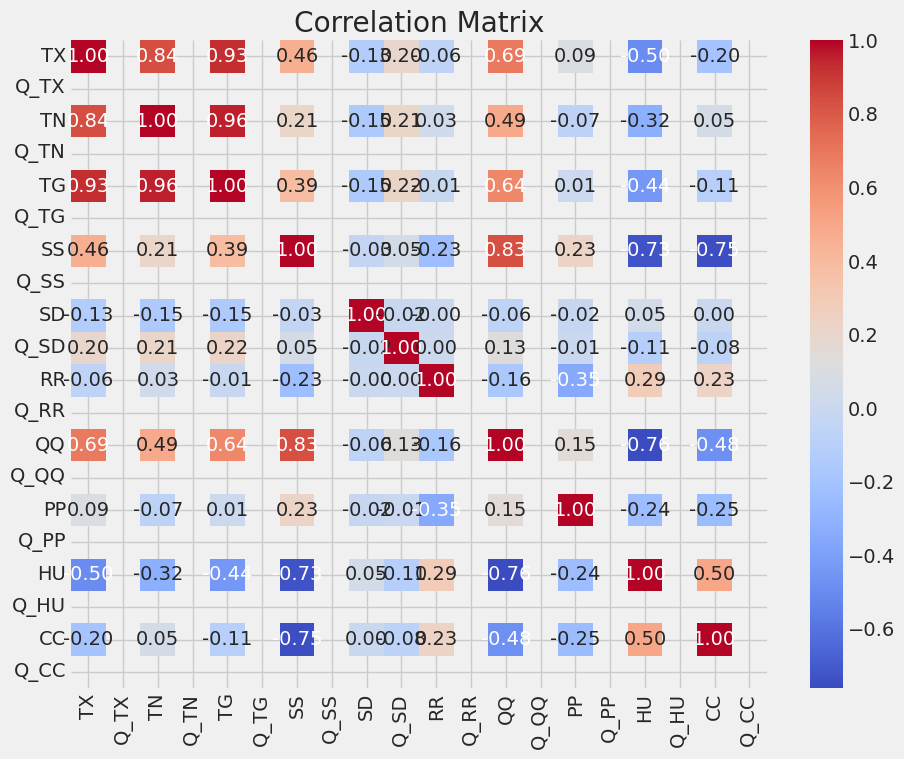

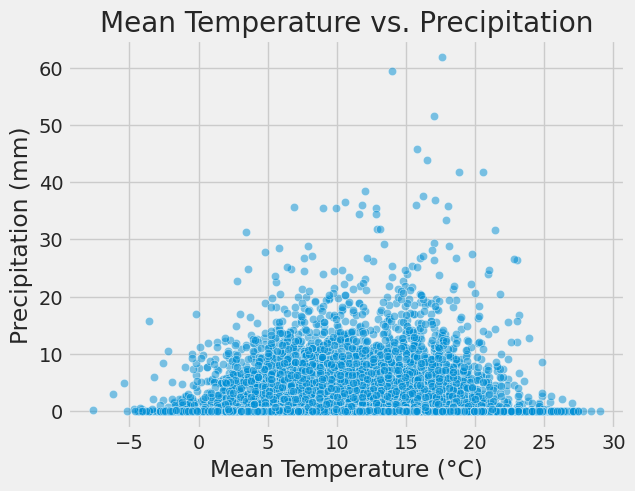

In [13]:
# Correlation Matrix
corr_matrix = valid_data.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

# Temperature vs Precipitation
sns.scatterplot(x='TG', y='RR', data=valid_data, alpha=0.5)
plt.title('Mean Temperature vs. Precipitation')
plt.xlabel('Mean Temperature (°C)')
plt.ylabel('Precipitation (mm)')
plt.show()


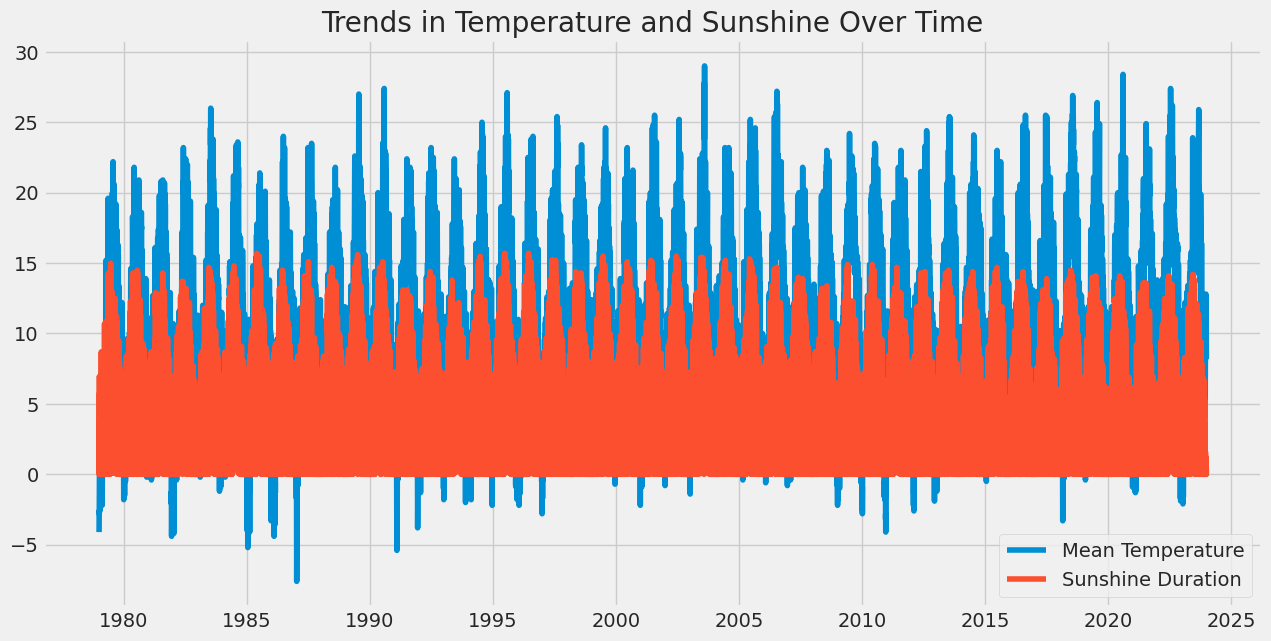

In [15]:
# Visualize trends and seasonality in key features over time.

# Plot time series
plt.figure(figsize=(14, 7))
plt.plot( valid_data['TG'], label='Mean Temperature')
plt.plot( valid_data['SS'], label='Sunshine Duration')
plt.title('Trends in Temperature and Sunshine Over Time')
plt.legend()
plt.show()


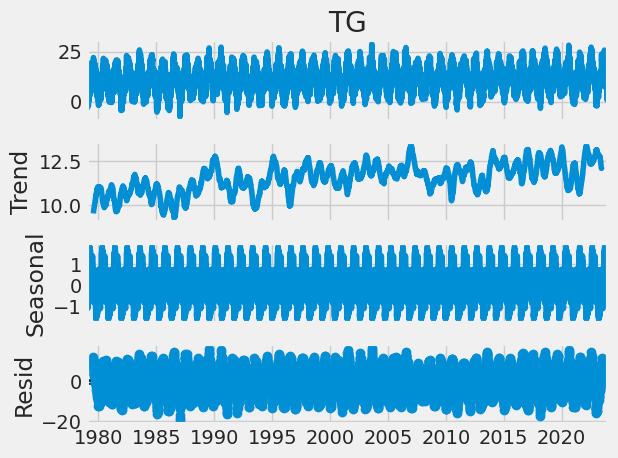

In [19]:
# Decompose the time series (e.g., TG - daily mean temperature)
result = seasonal_decompose(valid_data['TG'].dropna(), model='additive', period=365)  # period=365 for daily data

# Plot decomposition results
result.plot()
plt.show()

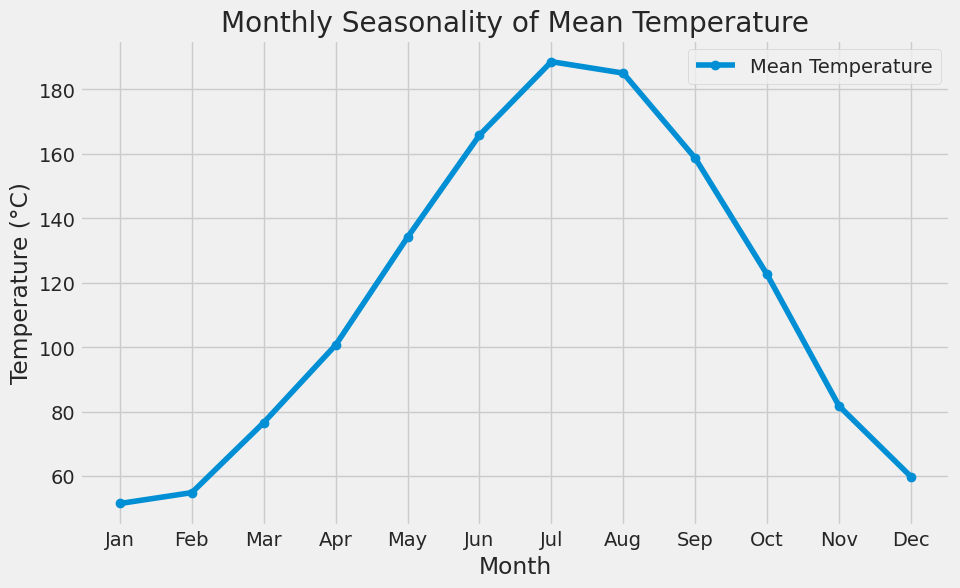

In [20]:
# Group by month to observe seasonal patterns
monthly_seasonality = data.groupby(data.index.month).mean()

# Plot monthly seasonality
plt.figure(figsize=(10, 6))
plt.plot(monthly_seasonality.index, monthly_seasonality['TG'], marker='o', label='Mean Temperature')
plt.title('Monthly Seasonality of Mean Temperature')
plt.xlabel('Month')
plt.ylabel('Temperature (°C)')
plt.xticks(range(1, 13), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.legend()
plt.show()


In [32]:
print(data.head()) 

              TX  Q_TX    TN  Q_TN    TG  Q_TG    SS  Q_SS   SD  Q_SD   RR  \
DATE                                                                         
1979-01-01  23.0     0 -75.0     0 -41.0     0  70.0     0  9.0     0  4.0   
1979-01-02  16.0     0 -75.0     0 -26.0     0  17.0     0  8.0     0  0.0   
1979-01-03  13.0     0 -72.0     0 -28.0     0   0.0     0  4.0     0  0.0   
1979-01-04  -3.0     0 -65.0     0 -26.0     0   0.0     0  2.0     0  0.0   
1979-01-05  56.0     0 -14.0     0  -8.0     0  20.0     0  1.0     0  0.0   

            Q_RR    QQ  Q_QQ       PP  Q_PP    HU  Q_HU   CC  Q_CC  
DATE                                                                
1979-01-01     0  52.0     0  10190.0     0  83.0     0  2.0     0  
1979-01-02     0  27.0     0  10253.0     0  76.0     0  6.0     0  
1979-01-03     0  13.0     0  10205.0     0  86.0     0  5.0     0  
1979-01-04     0  13.0     0  10084.0     0  68.0     0  8.0     0  
1979-01-05     0  29.0     0  10225.0  

In [31]:
# Group by year and month to compute the average temperature
year_month_data = (
    data['TG']
    .groupby([data.index.year, data.index.month])
    .mean()
    .reset_index()
)

# Rename columns explicitly
year_month_data.columns = ['Year', 'Month', 'Mean_Temperature']

# Pivot for heatmap
seasonal_pivot = year_month_data.pivot(index='Year', columns='Month', values='Mean_Temperature')


plt.figure(figsize=(12, 8))
sns.heatmap(seasonal_pivot, cmap='coolwarm', annot=False, cbar=True)
plt.title('Yearly Seasonal Trends in Mean Temperature')
plt.xlabel('Month')
plt.ylabel('Year')
plt.show()


ValueError: cannot insert DATE, already exists

In [47]:

# Perform FFT on the time series
fft_values = fft(data['TG'])
frequencies = np.fft.fftfreq(len(fft_values))

# Plot the power spectrum
plt.figure(figsize=(10, 6))
plt.plot(frequencies, np.abs(fft_values))
plt.title('Fourier Transform - Seasonality Detection')
plt.xlabel('Frequency')
plt.ylabel('Amplitude')
plt.show()

data = data.drop(columns=['ALIGNED'], errors='ignore')

KeyError: 'ALIGNED'

In [49]:
# Add seasonality features
data['Month'] = data.index.month
data['DayOfYear'] = data.index.dayofyear
data['WeekOfYear'] = data.index.isocalendar().week

# Sin/Cos transformations
data['Sin_Month'] = np.sin(2 * np.pi * data['Month'] / 12)
data['Cos_Month'] = np.cos(2 * np.pi * data['Month'] / 12)


In [50]:
print(data.head()) 

              TX  Q_TX    TN  Q_TN    TG  Q_TG    SS  Q_SS   SD  Q_SD  ...  \
DATE                                                                   ...   
1979-01-01  23.0     0 -75.0     0 -41.0     0  70.0     0  9.0     0  ...   
1979-01-02  16.0     0 -75.0     0 -26.0     0  17.0     0  8.0     0  ...   
1979-01-03  13.0     0 -72.0     0 -28.0     0   0.0     0  4.0     0  ...   
1979-01-04  -3.0     0 -65.0     0 -26.0     0   0.0     0  2.0     0  ...   
1979-01-05  56.0     0 -14.0     0  -8.0     0  20.0     0  1.0     0  ...   

            Q_PP    HU  Q_HU   CC  Q_CC  Month  DayOfYear  WeekOfYear  \
DATE                                                                    
1979-01-01     0  83.0     0  2.0     0      1          1           1   
1979-01-02     0  76.0     0  6.0     0      1          2           1   
1979-01-03     0  86.0     0  5.0     0      1          3           1   
1979-01-04     0  68.0     0  8.0     0      1          4           1   
1979-01-05     

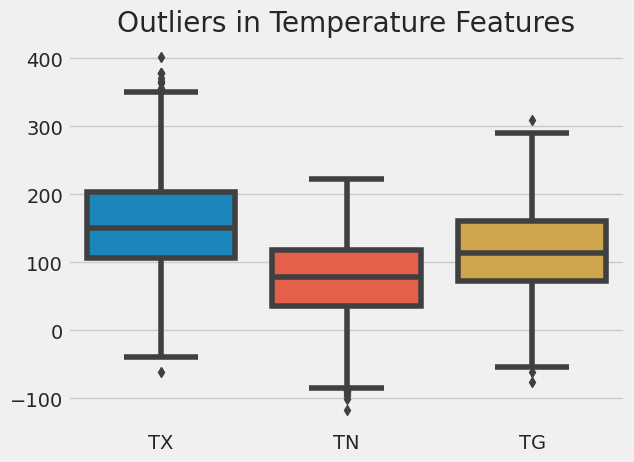

Number of outliers: 22


In [51]:
# Boxplot for outliers
sns.boxplot(data=data[['TX', 'TN', 'TG']])
plt.title('Outliers in Temperature Features')
plt.show()

# Z-score method
from scipy.stats import zscore
z_scores = np.abs(zscore(data[['TX', 'TN', 'TG']]))
outliers = (z_scores > 3).any(axis=1)
print(f"Number of outliers: {outliers.sum()}")


In [53]:
# Feature Engineering
# Add temperature range feature
data['TEMP_RANGE'] = data['TX'] - data['TN']

# Normalize radiation
data['QQ_NORM'] = data['QQ'] / data['QQ'].max()

print(data.head())


              TX  Q_TX    TN  Q_TN    TG  Q_TG    SS  Q_SS   SD  Q_SD  ...  \
DATE                                                                   ...   
1979-01-01  23.0     0 -75.0     0 -41.0     0  70.0     0  9.0     0  ...   
1979-01-02  16.0     0 -75.0     0 -26.0     0  17.0     0  8.0     0  ...   
1979-01-03  13.0     0 -72.0     0 -28.0     0   0.0     0  4.0     0  ...   
1979-01-04  -3.0     0 -65.0     0 -26.0     0   0.0     0  2.0     0  ...   
1979-01-05  56.0     0 -14.0     0  -8.0     0  20.0     0  1.0     0  ...   

            Q_HU   CC  Q_CC  Month  DayOfYear  WeekOfYear  Sin_Month  \
DATE                                                                   
1979-01-01     0  2.0     0      1          1           1        0.5   
1979-01-02     0  6.0     0      1          2           1        0.5   
1979-01-03     0  5.0     0      1          3           1        0.5   
1979-01-04     0  8.0     0      1          4           1        0.5   
1979-01-05     0  6.0

In [54]:
# Normalization

scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(valid_data)

# Convert scaled data back to DataFrame
scaled_data = pd.DataFrame(scaled_data, index=valid_data.index, columns=valid_data.columns)

print(scaled_data.head())


                  TX  Q_TX        TN  Q_TN        TG  Q_TG        SS  Q_SS  \
DATE                                                                         
1979-01-01  0.128736   0.0  0.130303   0.0  0.095628   0.0  0.445860   0.0   
1979-01-02  0.112644   0.0  0.130303   0.0  0.136612   0.0  0.108280   0.0   
1979-01-03  0.105747   0.0  0.139394   0.0  0.131148   0.0  0.000000   0.0   
1979-01-04  0.068966   0.0  0.160606   0.0  0.136612   0.0  0.000000   0.0   
1979-01-05  0.204598   0.0  0.315152   0.0  0.185792   0.0  0.127389   0.0   

                  SD  Q_SD  ...        QQ  Q_QQ        PP  Q_PP        HU  \
DATE                        ...                                             
1979-01-01  0.409091   0.0  ...  0.122905   0.0  0.674234   0.0  0.746269   
1979-01-02  0.363636   0.0  ...  0.053073   0.0  0.745743   0.0  0.641791   
1979-01-03  0.181818   0.0  ...  0.013966   0.0  0.691260   0.0  0.791045   
1979-01-04  0.090909   0.0  ...  0.013966   0.0  0.553916   0.0  0.5

In [55]:
# Time Series Setup
# Create Sequences

import numpy as np

def create_sequences(data, time_steps):
    sequences = []
    labels = []
    for i in range(len(data) - time_steps):
        seq = data[i:i + time_steps]
        label = data[i + time_steps]
        sequences.append(seq)
        labels.append(label)
    return np.array(sequences), np.array(labels)

time_steps = 30  # Example: Use 30 days to predict the next day
X, y = create_sequences(scaled_data.values, time_steps)

print(f"Input shape: {X.shape}, Output shape: {y.shape}")


Input shape: (15106, 30, 22), Output shape: (15106, 22)


In [56]:
# Train-Test Split
split_ratio = 0.8
split_index = int(len(X) * split_ratio)

X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

print(f"Train shape: {X_train.shape}, Test shape: {X_test.shape}")


Train shape: (12084, 30, 22), Test shape: (3022, 30, 22)


In [57]:
# Model Design

# Define the model
model = Sequential([
    LSTM(50, activation='relu', input_shape=(time_steps, X.shape[2])),
    Dense(1)
])

# Compile the model
model.compile(optimizer='adam', loss='mse')
print(model.summary())


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 50)                  │          14,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,651 (57.23 KB)

 Trainable params: 14,651 (57.23 KB)

 Non-trainable params: 0 (0.00 B)

None


In [58]:
# Training

# Train the model
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test), verbose=1)

# Save the model
model.save('lstm_weather_model.h5')


Epoch 1/20
378/378 ━━━━━━━━━━━━━━━━━━━━ 8s 16ms/step - loss: 0.0970 - val_loss: 0.0820
Epoch 2/20
378/378 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - loss: 0.0823 - val_loss: 0.0820
Epoch 3/20
378/378 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - loss: 0.0825 - val_loss: 0.0820
Epoch 4/20
378/378 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - loss: 0.0826 - val_loss: 0.0819
Epoch 5/20
378/378 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - loss: 0.0820 - val_loss: 0.0819
Epoch 6/20
378/378 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - loss: 0.0822 - val_loss: 0.0819
Epoch 7/20
378/378 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - loss: 0.0822 - val_loss: 0.0819
Epoch 8/20
378/378 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - loss: 0.0825 - val_loss: 0.0820
Epoch 9/20
378/378 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - loss: 0.0819 - val_loss: 0.0819
Epoch 10/20
378/378 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - loss: 0.0821 - val_loss: 0.0819
Epoch 11/20
378/378 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - loss: 0.0818 - val_loss: 0.0819
Epoch 12/20
378/378 ━━━━━━━━━━━━━━━━━━━━ 

95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0792
Test Loss: 0.08193027228116989
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step


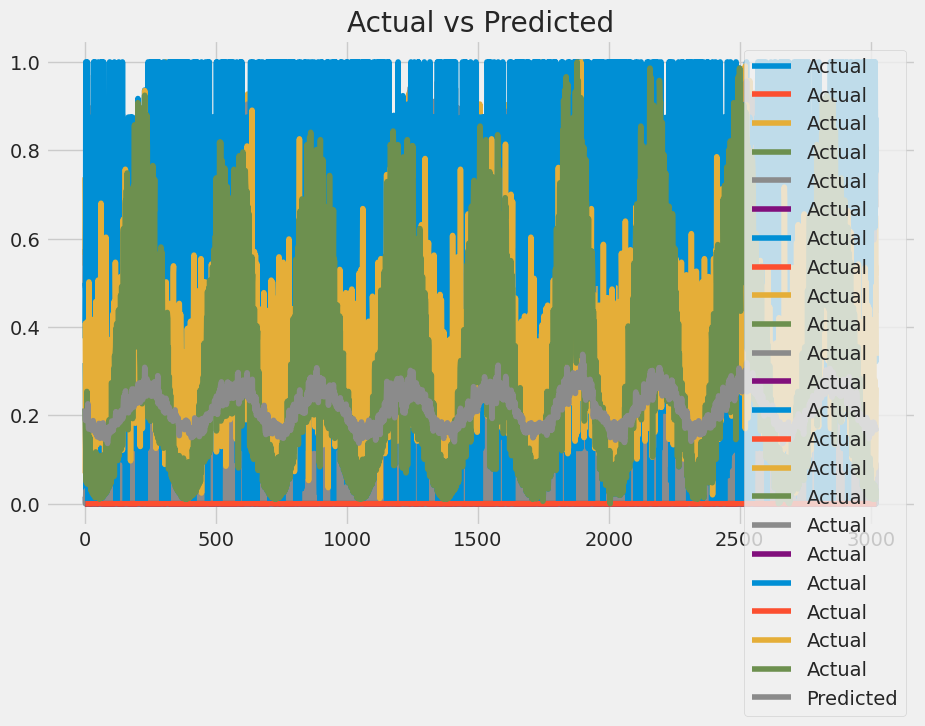

In [59]:

# Evaluate the model
loss = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss}")

# Predictions
predictions = model.predict(X_test)

# Visualize predictions vs actual
plt.figure(figsize=(10, 6))
plt.plot(y_test, label='Actual')
plt.plot(predictions, label='Predicted')
plt.legend()
plt.title('Actual vs Predicted')
plt.show()


In [ ]:
# Deployment

# # Load the saved model
# deployed_model = load_model('lstm_weather_model.h5')

# # Use the model for predictions
# new_predictions = deployed_model.predict(X_test[:10])  # Example: Predict first 10 sequences
# print(new_predictions)
